# Random Sampling and distance-based Statistics

# Resampling

estimating statistics using random samples.

let's consider the idea of p-value:

given a test statistics from the observed data and a null hypothesis (a generation process), what are the chances of osberving a value greater than the one obtained on the data if the data was generated from the null hypothesis?

## the t-test statistics

the simplest example is the one-sample t-test:
 is the observed mean of a sample compatible with 0?

In [1]:
import numpy as np
import pylab as plt
import scipy.stats as st
import seaborn as sns

In [37]:
data_1 = np.array([1.35, 1.01, 0.25, 0.39, -1.57])
st.ttest_1samp(data_1, 0)

Ttest_1sampResult(statistic=0.5656372970687832, pvalue=0.6018616929196308)

in this case the statistic is defined as the mean divided the standard deviation of the mean:

$$t = \frac{Z}{s} = \frac{\bar{X} – \mu}{\frac{\hat{\sigma}}{\sqrt{n}}}$$

In [42]:
mean_1 = np.mean(data_1)
std_1 = np.std(data_1, ddof=1)
print(mean_1, std_1, mean_1/(std_1/np.sqrt(len(data_1))))

0.2860000000000001 1.130610454577526 0.5656372970687832


In [44]:
np.mean(data_1)/st.sem(data_1)

0.5656372970687832

In [45]:
def t_stat(data):
    return np.mean(data)/st.sem(data)

In [47]:
n_data = len(data_1)
data_fake_1 = plt.randn(n_data)
t_stat(data_fake_1)

0.11223874999398128

In [ ]:
distribution = [t_stat(plt.randn(n_data)) for i in range(100_000)]

(-5.0, 5.0)

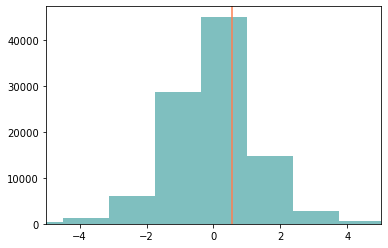

In [57]:
fig, ax = plt.subplots()
ax.hist(distribution, bins=50, alpha=0.5, color='teal')
ax.axvline(t_stat(data_1), color='coral')
ax.set_xlim(-5, 5)

In [58]:
greater = np.abs(np.array(distribution))>abs(t_stat(data_1))
p_value = sum(greater)/len(greater)
print(p_value)

0.6023


In [59]:
st.ttest_1samp(data_1, 0)

Ttest_1sampResult(statistic=0.5656372970687832, pvalue=0.6018616929196308)

this can be applied in a more general sense: given any statistical generative procedure, what is the chance of observing values more extreme than the given ones?

## correcting for the "real" process

for example, in this case we should have included the truncation procedure in out data! (we only have two decimal digits).

In [60]:
def gen_fake(n):
    fake_data = plt.randn(n)
    return fake_data.round(2)
gen_fake(5)

array([-0.33,  0.52, -0.65, -1.32, -0.38])

In [65]:
distribution = [t_stat(gen_fake(n_data)) for i in range(100_000)]

In [66]:
greater = np.abs(np.array(distribution))>abs(t_stat(data_1))
p_value = sum(greater)/len(greater)
print(p_value)

0.59904


of course, we could also perform several generation to have an estimate of our uncertainty in the p-value

In [67]:
for i in range(8):
    distribution = [t_stat(gen_fake(n_data)) for i in range(1_000)]
    greater = np.abs(np.array(distribution))>abs(t_stat(data_1))
    p_value = sum(greater)/len(greater)
    print(p_value)

0.591
0.605
0.614
0.604
0.599
0.609
0.631
0.609


# Perfect Sampling (Bayesian statistics)

http://www.sumsar.net/blog/2014/10/tiny-data-and-the-socks-of-karl-broman/

a similar procedure can the used to perform bayesian inference, in particular for simple models:

1. extract from the prior distribution of the parameters
2. generate some random data with those parameters
3. if the data are similar enough to the observed data (or equal) keep those parameters
4. repeat until enough parameters are observed

This class of methods allow us to answer more complex questions naturally!

NOTE: as far as I know, there is no particular advantage is using low discrepancy sequences here, the randomness compound too much

**experiment**:

we observe a biased coin with 7 heads and 3 tails.

what is the probability of the coin coming out with tail the next toss?

from formal analysis, we can derive the distribution as ${Beta}(7+\alpha, 3+\beta)$

where $\alpha$ and $\beta$ are the prior parameters (already known information)

In [2]:
def plot_beta(dist, ax=None, base=np.linspace(0, 1, 10_000), **kwargs):
    if ax is None:
        ax=plt.gca()
    pdf = dist.pdf(base)
    kwargs.setdefault("alpha", 0.5)
    ax.fill_between(base, pdf, 0, **kwargs)

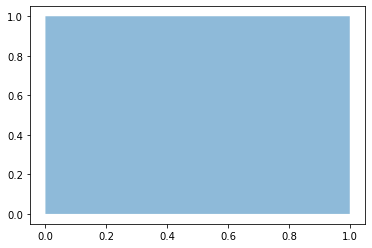

In [3]:
α, β = 1, 1
prior = st.beta(α, β)
plot_beta(prior)

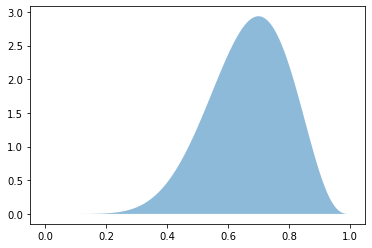

In [21]:
α, β = 1, 1
true_posterior = st.beta(7+α, 3+β)
plot_beta(true_posterior)

In [73]:
np.random.seed(42)
N_samples = 10
sampled_prior = prior.rvs(N_samples)
print(sampled_prior)

[0.52232255 0.49999941 0.5272587  0.46421572 0.57900808 0.45226229
 0.55805831 0.47652842 0.48880595 0.53794006]


In [74]:
st.binom.rvs(n=10, p=sampled_prior)

array([6, 6, 6, 5, 6, 3, 3, 6, 7, 3])

In [75]:
fake_observations = st.binom.rvs(n=10, p=sampled_prior)

In [76]:
observed = 7
coherent = (fake_observations==7)
selected_prior = sampled_prior[coherent]
print(len(selected_prior))

2


In [77]:
observed = 7
N_samples = 100
sampled_prior = prior.rvs(N_samples)
fake_observations = st.binom.rvs(n=10, p=sampled_prior)
coherent = (fake_observations==7)
selected_prior = sampled_prior[coherent]
print(len(selected_prior))

12


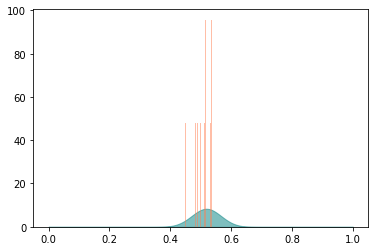

In [80]:
plt.hist(selected_prior, bins=50, density=True, alpha=0.5, color="coral");
plot_beta(true_posterior, color='teal')

In [81]:
%%time
observed = 7
N_samples = 100_000
sampled_prior = prior.rvs(N_samples)
fake_observations = st.binom.rvs(n=10, p=sampled_prior)
coherent = (fake_observations==observed)
selected_prior = sampled_prior[coherent]
n_accepted = len(selected_prior)
s = "accepted samples: {}\nacceptance fraction: {}%\n-----"
print(s.format(n_accepted, 100*n_accepted/N_samples))

accepted samples: 12234
acceptance fraction: 12.234%
-----
CPU times: user 55.5 ms, sys: 0 ns, total: 55.5 ms
Wall time: 56.1 ms


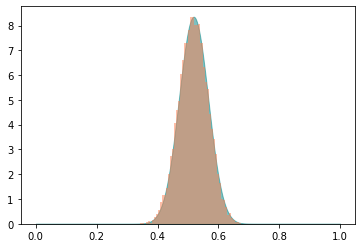

In [82]:
plt.hist(selected_prior, bins=50, density=True, alpha=0.5, color="coral");
plot_beta(true_posterior, color='teal')

# how do different priors affect me?

with this approach I can model how the belief on the possible values of the parameters could affect my final result

In [15]:
def fit_probability(successes=7, failures=3, α=1, β=1, N_samples=100_000):
    prior = st.beta(α, β)
    true_posterior = st.beta(successes+α, failures+β)
    sampled_prior = prior.rvs(N_samples)
    n_observations = successes+failures
    fake_observations = st.binom.rvs(n=n_observations, p=sampled_prior)
    coherent = (fake_observations==successes)
    selected_prior = sampled_prior[coherent]
    return prior, true_posterior, selected_prior

accepted samples: 6661
acceptance fraction: 6.661%
-----


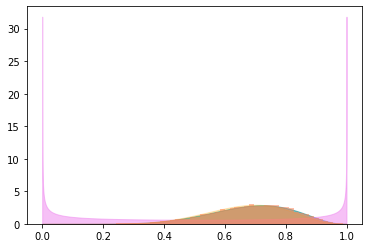

In [30]:
result = fit_probability(successes=7, failures=3, α=0.5, β=0.5, N_samples=100_000)
prior, true_posterior, selected_prior = result
n_accepted = len(selected_prior)
s = "accepted samples: {}\nacceptance fraction: {}%\n-----"
print(s.format(n_accepted, 100*n_accepted/N_samples))
plt.hist(selected_prior, bins=50, density=True, alpha=0.5, color="coral");
plot_beta(true_posterior, color='teal')
plot_beta(prior, color='violet')
plot_beta(st.beta(1+7, 1+3), color='orange', alpha=0.25)

accepted samples: 9084
acceptance fraction: 9.084%
-----


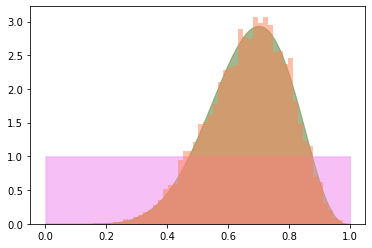

In [31]:
result = fit_probability(successes=7, failures=3, α=1, β=1, N_samples=100_000)
prior, true_posterior, selected_prior = result
n_accepted = len(selected_prior)
s = "accepted samples: {}\nacceptance fraction: {}%\n-----"
print(s.format(n_accepted, 100*n_accepted/N_samples))
plt.hist(selected_prior, bins=50, density=True, alpha=0.5, color="coral");
plot_beta(true_posterior, color='teal')
plot_beta(prior, color='violet')
plot_beta(st.beta(1+7, 1+3), color='orange', alpha=0.25)

accepted samples: 12391
acceptance fraction: 12.391%
-----


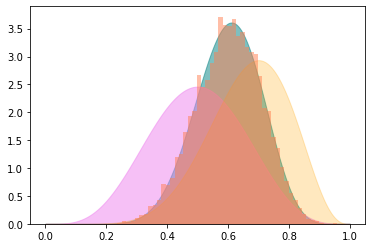

In [32]:
result = fit_probability(successes=7, failures=3, α=5, β=5, N_samples=100_000)
prior, true_posterior, selected_prior = result
n_accepted = len(selected_prior)
s = "accepted samples: {}\nacceptance fraction: {}%\n-----"
print(s.format(n_accepted, 100*n_accepted/N_samples))
plt.hist(selected_prior, bins=50, density=True, alpha=0.5, color="coral");
plot_beta(true_posterior, color='teal')
plot_beta(prior, color='violet')
plot_beta(st.beta(1+7, 1+3), color='orange', alpha=0.25)

accepted samples: 11882
acceptance fraction: 11.882%
-----


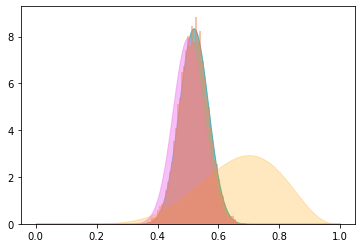

In [33]:
result = fit_probability(successes=7, failures=3, α=50, β=50, N_samples=100_000)
prior, true_posterior, selected_prior = result
n_accepted = len(selected_prior)
s = "accepted samples: {}\nacceptance fraction: {}%\n-----"
print(s.format(n_accepted, 100*n_accepted/N_samples))
plt.hist(selected_prior, bins=50, density=True, alpha=0.5, color="coral");
plot_beta(true_posterior, color='teal')
plot_beta(prior, color='violet')
plot_beta(st.beta(1+7, 1+3), color='orange', alpha=0.25)

# discontinuous model

we could try to decide if the coin is biased or not, rather than estimating a probability

to do this, we need hyperparameters describing the set of models

In [95]:
α_of_bias, β_of_bias = 1, 1
belief_coin_biased = 0.1

n_observations = 10
successes = 10

N_samples = 100_000

coin_is_biased_prior = st.binom(n=1, p=belief_coin_biased)
coin_is_biased_prior_samples = coin_is_biased_prior.rvs(N_samples).astype(bool)

p_coin_if_biased_prior = st.beta(α_of_bias, β_of_bias)
p_coin_if_biased_prior_samples = p_coin_if_biased_prior.rvs(N_samples)

p_coin_effective = np.where(coin_is_biased_prior_samples, p_coin_if_biased_prior_samples, 0.5)

fake_observations = st.binom.rvs(n=n_observations, p=p_coin_effective)
coherent = (fake_observations==successes)
p_coin_posterior = p_coin_effective[coherent]
p_coin_posterior_if_biased = p_coin_effective[coherent&coin_is_biased_prior_samples]
p_coin_is_biased_posterior = (coin_is_biased_prior_samples&coherent).sum()/coherent.sum()

print(coherent.sum())
print(len(p_coin_posterior_if_biased))
print(p_coin_is_biased_posterior)

971
890
0.9165808444902163


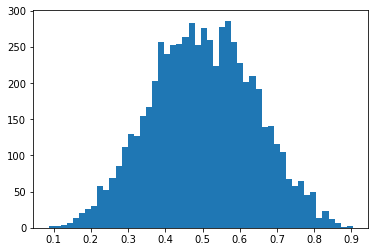

In [90]:
plt.hist(p_coin_posterior_if_biased, bins=50);

# What happens if we have multiple coins?

In [128]:
np.random.seed(2)
observed = np.array([7, 8, 9])
n_trials = len(observed)

N_samples = 6
prior = st.beta(1, 1)
sampled_prior = prior.rvs(N_samples)
fake_observations = st.binom.rvs(n=10, p=sampled_prior, size=(n_trials, N_samples))

In [129]:
fake_observations

array([[10,  4,  4,  2,  4,  0],
       [10,  8,  6,  1,  7,  2],
       [10,  8,  7,  2,  5,  1]])

In [130]:
fake_observations==observed.reshape(-1, 1)

array([[False, False, False, False, False, False],
       [False,  True, False, False, False, False],
       [False, False, False, False, False, False]])

In [131]:
(fake_observations==observed.reshape(-1, 1)).all(axis=0)

array([False, False, False, False, False, False])

In [138]:
np.random.seed(2)
observed = np.array([7, 8, 9])
n_trials = len(observed)

N_samples = 1_000_000
prior = st.beta(1, 1)
sampled_prior = prior.rvs(N_samples)
fake_observations = st.binom.rvs(n=10, p=sampled_prior, size=(n_trials, N_samples))
(fake_observations==observed.reshape(-1, 1)).all(axis=0).sum()

2972

very low acceptance stops us from finding results

but we're being too bad with ourselves: we don't care about the ordering of the data, as it is completely arbitrary!

we might test the **sorted** data!

In [133]:
np.random.seed(2)
observed = np.array([7, 8, 9])
n_trials = len(observed)

N_samples = 6
prior = st.beta(1, 1)
sampled_prior = prior.rvs(N_samples)
fake_observations = st.binom.rvs(n=10, p=sampled_prior, size=(n_trials, N_samples))

In [134]:
fake_observations

array([[10,  4,  4,  2,  4,  0],
       [10,  8,  6,  1,  7,  2],
       [10,  8,  7,  2,  5,  1]])

In [135]:
np.sort(fake_observations, axis=0)

array([[10,  4,  4,  1,  4,  0],
       [10,  8,  6,  2,  5,  1],
       [10,  8,  7,  2,  7,  2]])

In [139]:
np.random.seed(2)
observed = np.array([7, 8, 9]).reshape(-1, 1)
n_trials = len(observed)

N_samples = 1_000_000
prior = st.beta(1, 1)
sampled_prior = prior.rvs(N_samples)
fake_observations = st.binom.rvs(n=10, p=sampled_prior, size=(n_trials, N_samples))

fake_observations = np.sort(fake_observations, axis=0)
observed = np.sort(observed, axis=0)

(fake_observations==observed).all(axis=0).sum()

17555

In [140]:
17555/2972

5.906796769851952

we captured 6 times more cases!

this approach is extremely useful when there is some invariant in my data (for example permutations)

## sampling requirement limitations

a common problem of this approach is that increasing the number of data and the dimensionality (in particular if the prior is strongly different from the posterior), the number of sampling required is incredibly high.

on the upside, we can easily parallelize the computation, but it is often not enough.

in the extreme case of real valued parameters, the probability of exact sampling is exactly zero!

NOTE: for continuous values it is still formally possible to perform perfect sampling on real data, considering that the measurement procedure involves always a rounding/truncation procedure... 

formally the probabily is not 0 anymore, but it's still incredibly low unless the rounding is very strong

## distance based approach

to increase the sampling rate, with a (non trivial) reduction in the quality of the fit, one possibility is to use

#### Approximated Bayesian Computation

the idea is that we accept any data that is close enough, where "close" is defined over a set of measurements instead of the whole dataset.

examples could be: mean, standard deviation, rate, etc...

**IMPORTANT**: the result depends also on the chosen threshold!

if we are working in the exponential distribution family and use the natural parametrization, the result should be unbiased

## non likelihood-based approaches

One of the bis advantages of this approach is that one doesn't need to be able to define a likelihood function: if the data can be simulated in any way from the priors, we don't need anything else.

likelihood based models are exremely more efficient computation wise, but often are suffer from a **"specification problem"**: I can only model what I can represent with composition of simple distributions

one simple example can be shown with ODE.
They are not random, but it can still be used to perform a fit!

In [90]:
from scipy.optimize import curve_fit
from scipy.integrate import odeint

# derivative
def logistic(state, time, α, β):
    N = state
    δN = α*N*(1-N/β)
    return δN

def logistic_predict(N0, α, β, time):
    res = odeint(logistic, y0=N0, t=time, args=(α, β))
    return res.ravel()

time = np.linspace(0, 5, 2**3)
N0, α, β = 1, 1, 10
original = logistic_predict(N0, α, β, time)
original

array([1.        , 1.84983933, 3.16770552, 4.86411522, 6.59242029,
       7.98058516, 8.89779416, 9.42825654])

we could use as a distance the sum of the square of the differences

In [91]:
N0_hat, α_hat, β_hat = 1.1, 1.1,9.9
sampled = logistic_predict(N0_hat, α_hat, β_hat, time)
sampled

array([1.1       , 2.13070378, 3.7190289 , 5.63292789, 7.35909333,
       8.55384672, 9.23739986, 9.58657484])

In [92]:
def dist(samp1, samp2):
    return np.sqrt(np.sum((samp1-samp2)**2))

dist(original, sampled)

1.4285406231844497

let's try a threshold of one, with some simple priors

In [94]:
def plot_dist(dist, ax=None, base=np.linspace(0, 20, 10_000), **kwargs):
    if ax is None:
        ax=plt.gca()
    pdf = dist.pdf(base)
    kwargs.setdefault("alpha", 0.5)
    ax.fill_between(base, pdf, 0, **kwargs)

In [98]:
N0_prior = st.gamma(1, scale=1, loc=0)
α_prior = st.gamma(1, scale=1, loc=0)
β_prior = st.gamma(1, scale=10, loc=0)

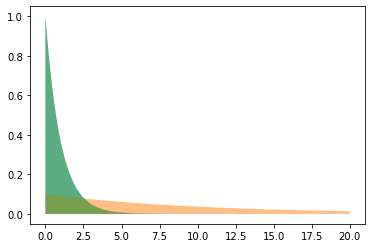

In [99]:
plot_dist(α_prior)
plot_dist(β_prior)
plot_dist(N0_prior)

In [100]:
N0_hat = N0_prior.rvs(1)
α_hat = α_prior.rvs(1)
β_hat = β_prior.rvs(1)
print(N0_hat, α_hat, β_hat)
sampled = logistic_predict(N0_hat, α_hat, β_hat, time)
print(sampled)
d = dist(original, sampled)
print(d)

[2.33472184] [1.02405695] [8.98527664]
[2.33472184 3.79010012 5.41414216 6.8204747  7.79476544 8.37011585
 8.67835905 8.83492298]
4.051848820347763


In [106]:
%%time
accepted = []
for i in range(100_000):
    N0_hat = N0_prior.rvs(1)
    α_hat = α_prior.rvs(1)
    β_hat = β_prior.rvs(1)
    sampled = logistic_predict(N0_hat, α_hat, β_hat, time)
    d = dist(original, sampled)
    if d<1:
        accepted.append([N0_hat, α_hat, β_hat])
accepted = np.array(accepted)
len(accepted)

CPU times: user 3min 37s, sys: 1.94 s, total: 3min 39s
Wall time: 3min 35s


116

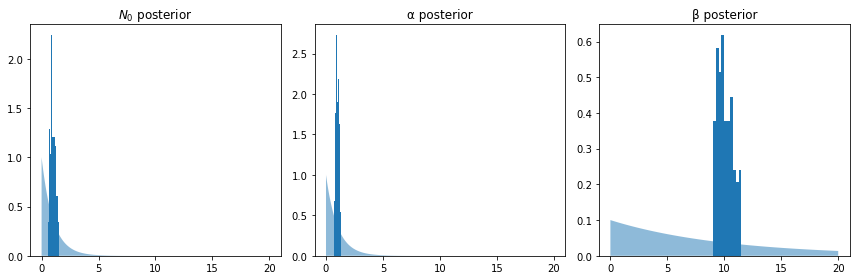

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(accepted[:, 0], density=True)
axes[1].hist(accepted[:, 1], density=True)
axes[2].hist(accepted[:, 2], density=True)
plot_dist(α_prior, ax=axes[1])
plot_dist(β_prior, ax=axes[2])
plot_dist(N0_prior, ax=axes[0])
axes[0].set_title("$N_0$ posterior")
axes[1].set_title("α posterior")
axes[2].set_title("β posterior")
fig.tight_layout()